In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
import plotly.graph_objs as go
import pandas_ta as ta

In [2]:
df1 = yf.download("IBM", start='2015-01-01', end='2020-12-31')
df1.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,154.216064,156.128113,153.919693,154.933075,102.338921,5779673
2015-01-05,154.177826,154.177826,152.189301,152.495224,100.728622,5104898
2015-01-06,152.648178,152.925430,148.346085,149.206497,98.556343,6429448
2015-01-07,150.286804,150.286804,147.256210,148.231354,97.912193,4918083
2015-01-08,149.369019,152.045883,148.709366,151.453156,100.040276,4431693


### Moving Average Crossover

In [4]:
# Initialize long and short windows
s_window = 50
l_window = 100

# Initialize a new DF to save signals
signals = pd.DataFrame(index=df1.index)
signals['signal'] = 0.0

In [5]:
signals.head()

,signal
Date,
2015-01-02,0.0
2015-01-05,0.0
2015-01-06,0.0
2015-01-07,0.0
2015-01-08,0.0


In [6]:
# Create short SMA over the short window
signals['short_SMA'] = df1['Close'].rolling(s_window, min_periods = 1, center=False).mean()

# Create short SMA over the short window
signals['long_SMA'] = df1['Close'].rolling(l_window, min_periods = 1, center=False).mean()

signals.head()

,signal,short_SMA,long_SMA
Date,,,
2015-01-02,0.0,154.933075,154.933075
2015-01-05,0.0,153.714149,153.714149
2015-01-06,0.0,152.211599,152.211599
2015-01-07,0.0,151.216537,151.216537
2015-01-08,0.0,151.263861,151.263861


In [7]:
# Create signals
#signals['signal'][s_window:] = np.where(signals['short_SMA'][s_window:] > signals['long_SMA'][s_window:], 1.0, 0.0)

In [8]:
# Create signals
signals.iloc[s_window:, signals.columns.get_loc('signal')] = np.where(signals.iloc[s_window:, signals.columns.get_loc('short_SMA')] > signals.iloc[s_window:, signals.columns.get_loc('long_SMA')], 1.0, 0.0)

signals.head()

,signal,short_SMA,long_SMA
Date,,,
2015-01-02,0.0,154.933075,154.933075
2015-01-05,0.0,153.714149,153.714149
2015-01-06,0.0,152.211599,152.211599
2015-01-07,0.0,151.216537,151.216537
2015-01-08,0.0,151.263861,151.263861


In [9]:
# Generate trading positions
signals['positions'] = signals['signal'].diff()
signals.head()

,signal,short_SMA,long_SMA,positions
Date,,,,
2015-01-02,0.0,154.933075,154.933075,NaN
2015-01-05,0.0,153.714149,153.714149,0.0
2015-01-06,0.0,152.211599,152.211599,0.0
2015-01-07,0.0,151.216537,151.216537,0.0
2015-01-08,0.0,151.263861,151.263861,0.0


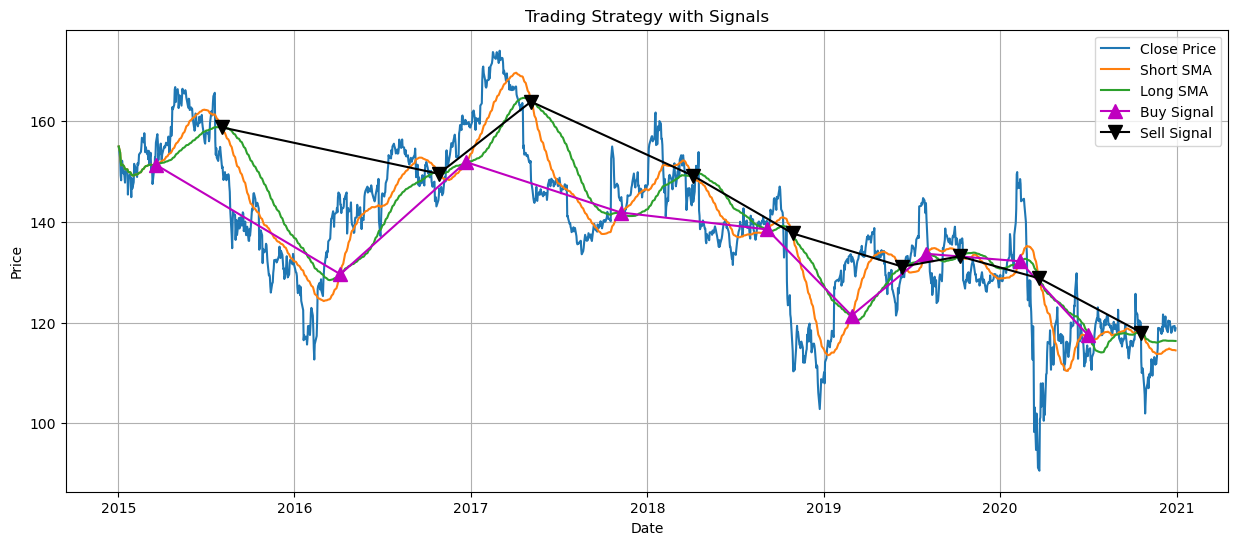

In [10]:
# Plotting results
plt.figure(figsize=(15, 6))

# Plot closing price
plt.plot(df1['Close'], label='Close Price')

# Plot short and long SMAs
plt.plot(signals['short_SMA'], label='Short SMA')
plt.plot(signals['long_SMA'], label='Long SMA')

# Plot buy signals (using markers on short SMA line)
buy_idx = signals[signals.positions == 1.0].index
plt.plot(buy_idx, signals.loc[buy_idx, 'short_SMA'], marker='^', markersize=10, color='m', label='Buy Signal')

# Plot sell signals (using markers on short SMA line)
sell_idx = signals[signals.positions == -1.0].index
plt.plot(sell_idx, signals.loc[sell_idx, 'short_SMA'], marker='v', markersize=10, color='k', label='Sell Signal')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Trading Strategy with Signals')
plt.grid(True)
plt.legend()

plt.show()

In [11]:
# Putting all the above in a function

def MA_strategy(df, short_window, long_window):
    # Initialize a new DF to save signals
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Create short SMA over the short window
    signals['short_SMA'] = df['Close'].rolling(short_window, min_periods = 1, center=False).mean()

    # Create short SMA over the short window
    signals['long_SMA'] = df['Close'].rolling(long_window, min_periods = 1, center=False).mean()

    # Create signals
    #signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)
    signals.iloc[s_window:, signals.columns.get_loc('signal')] = np.where(signals.iloc[s_window:, signals.columns.get_loc('short_SMA')] > signals.iloc[s_window:, signals.columns.get_loc('long_SMA')], 1.0, 0.0)

    #  Take the difference of the signals in order to generate actual trading orders
    signals['positions'] = signals['signal'].diff()

    # Plotting results
    plt.figure(figsize=(15, 6))

    # Plot closing price
    plt.plot(df['Close'], label='Close Price')

    # Plot short and long SMAs
    plt.plot(signals['short_SMA'], label='Short SMA')
    plt.plot(signals['long_SMA'], label='Long SMA')

    # Plot buy signals (using markers on short SMA line)
    buy_idx = signals[signals.positions == 1.0].index
    plt.plot(buy_idx, signals.loc[buy_idx, 'short_SMA'], marker='^', markersize=10, color='m', label='Buy Signal')

    # Plot sell signals (using markers on short SMA line)
    sell_idx = signals[signals.positions == -1.0].index
    plt.plot(sell_idx, signals.loc[sell_idx, 'short_SMA'], marker='v', markersize=10, color='k', label='Sell Signal')

    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Trading Strategy with Signals')
    plt.grid(True)
    plt.legend()

    plt.show()

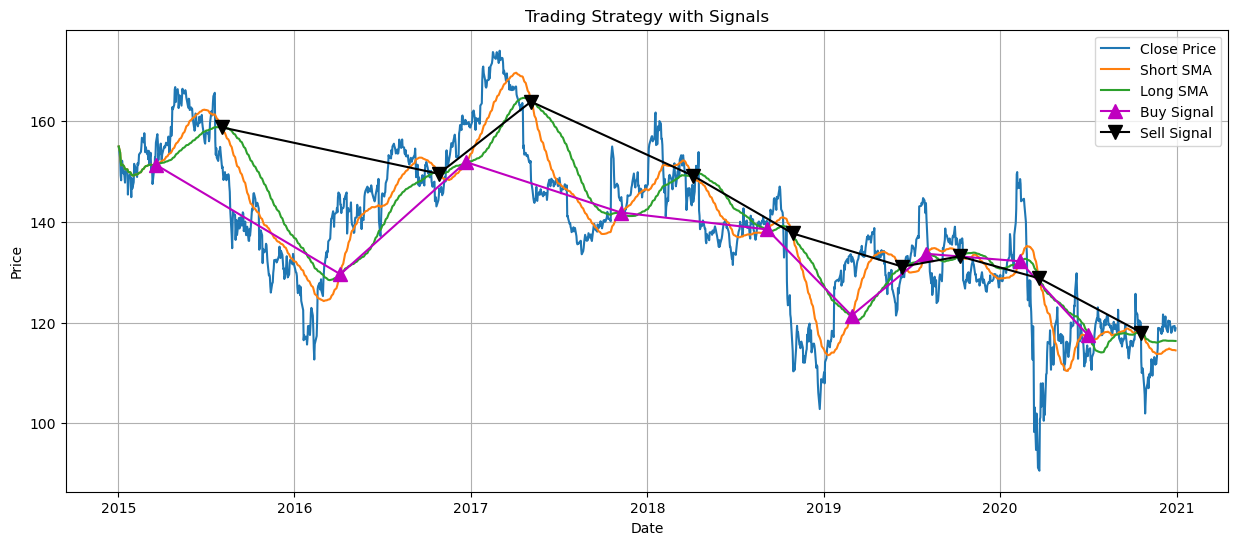

In [12]:
MA_strategy(df1, 50, 100)

### Backtest strategy

<Axes: xlabel='Date'>

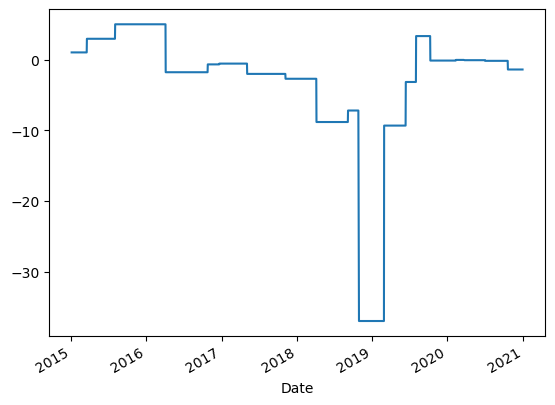

In [14]:
df1['Returns'] = df1['Close'].pct_change() * 100
df1['strategy_returns'] = df1['Returns'] * signals['positions']
cumulative_returns = (df1['strategy_returns'] + 1).cumprod()
cumulative_returns.plot()

In [15]:
signals

,signal,short_SMA,long_SMA,positions
Date,,,,
2015-01-02,0.0,154.933075,154.933075,NaN
2015-01-05,0.0,153.714149,153.714149,0.0
2015-01-06,0.0,152.211599,152.211599,0.0
2015-01-07,0.0,151.216537,151.216537,0.0
2015-01-08,0.0,151.263861,151.263861,0.0
...,...,...,...,...
2020-12-23,0.0,114.571702,116.394646,0.0
2020-12-24,0.0,114.547801,116.383652,0.0
2020-12-28,0.0,114.546463,116.377629,0.0


In [16]:
initial_capital = 10000  # Define your initial capital

# Create a dataframe for positions and holdings
positions = pd.DataFrame(index=signals.index).fillna(0.0)
portfolio = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares when the buy signal is triggered
positions['Holdings'] = 100*signals['positions']

# Sell all shares when the sell signal is triggered
#positions['Holdings'] = positions['Holdings'] - 100*trades['Sell_Signal']

# Can't sell if we don't have any
#positions['Holdings'] = positions['Holdings'].clip(lower=0)

# Initialize the portfolio with value owned
portfolio['Holdings'] = positions.multiply(df1['Close'], axis='index')

# Store the difference in shares owned
#pos_diff = positions.diff()

# Add `holdings` to portfolio
#portfolio = holdings

# Add `cash` to portfolio
portfolio['Cash'] = initial_capital - portfolio['Holdings'].cumsum()

# Add `total` to portfolio
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']

# Add `returns` to portfolio
portfolio['Returns'] = portfolio['Total'].pct_change()

In [17]:
# Initialize portfolio
portfolio = pd.DataFrame(index=signals.index)
portfolio['holdings'] = signals['signal'] * df1['Close']
portfolio['cash'] = initial_capital - (signals['positions'] * df1['Close']).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
portfolio

,holdings,cash,total,returns
Date,,,,
2015-01-02,0.0,NaN,NaN,NaN
2015-01-05,0.0,10000.00000,10000.00000,NaN
2015-01-06,0.0,10000.00000,10000.00000,0.0
2015-01-07,0.0,10000.00000,10000.00000,0.0
2015-01-08,0.0,10000.00000,10000.00000,0.0
...,...,...,...,...
2020-12-23,0.0,9892.15107,9892.15107,0.0
2020-12-24,0.0,9892.15107,9892.15107,0.0
2020-12-28,0.0,9892.15107,9892.15107,0.0


<Axes: xlabel='Date'>

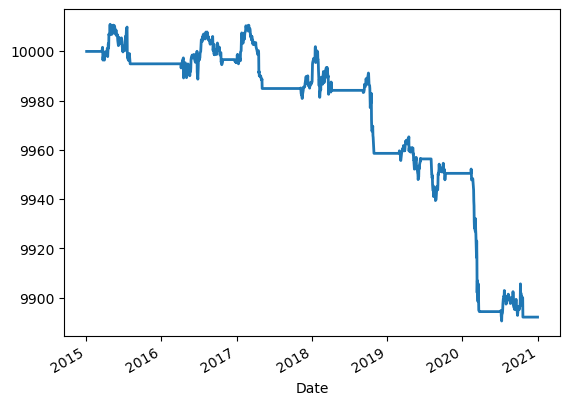

In [18]:
# Plot the equity curve in dollars
portfolio['total'].plot(lw=2.)

In [19]:
def MA_strategy(df, short_window, long_window, initial_capital=10000.0):
    # Initialize a new DataFrame to save signals
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Create short SMA over the short window
    signals['short_SMA'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long SMA over the long window
    signals['long_SMA'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)
    
    # Take the difference of the signals to generate actual trading orders
    signals['positions'] = signals['signal'].diff()

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['holdings'] = signals['signal'] * df['Close']
    portfolio['cash'] = initial_capital - (signals['positions'] * df['Close']).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    # Plotting results
    plt.figure(figsize=(15, 6))

    # Plot closing price
    plt.plot(df['Close'], label='Close Price', alpha=0.5)

    # Plot short and long SMAs
    plt.plot(signals['short_SMA'], label='Short SMA ({} days)'.format(short_window), alpha=0.5)
    plt.plot(signals['long_SMA'], label='Long SMA ({} days)'.format(long_window), alpha=0.5)

    # Plot buy signals (using markers on close price line)
    buy_idx = signals[signals.positions == 1.0].index
    plt.plot(buy_idx, df.loc[buy_idx, 'Close'], marker='^', markersize=10, color='g', label='Buy Signal', linestyle='None')

    # Plot sell signals (using markers on close price line)
    sell_idx = signals[signals.positions == -1.0].index
    plt.plot(sell_idx, df.loc[sell_idx, 'Close'], marker='v', markersize=10, color='r', label='Sell Signal', linestyle='None')

    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Trading Strategy with Signals')
    plt.grid(True)
    plt.legend()

    plt.show()

    # Plot portfolio value over time
    plt.figure(figsize=(15, 6))
    plt.plot(portfolio['total'], label='Portfolio Value', color='b')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.legend()

    plt.show()

    return portfolio, signals

C:\Users\admin\AppData\Local\Temp\ipykernel_3636\713740998.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)


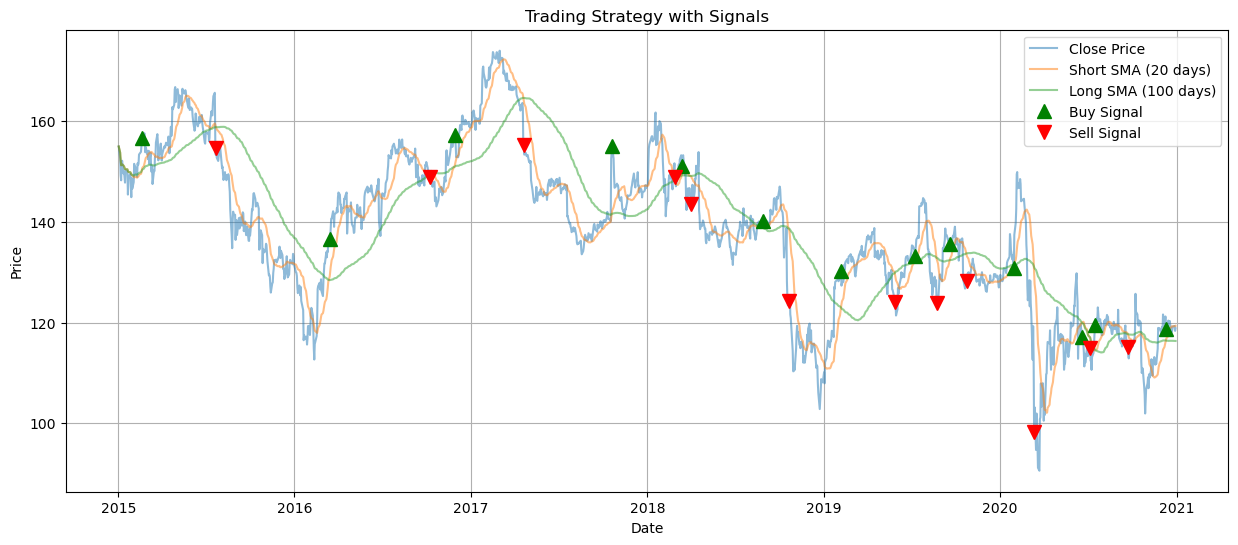

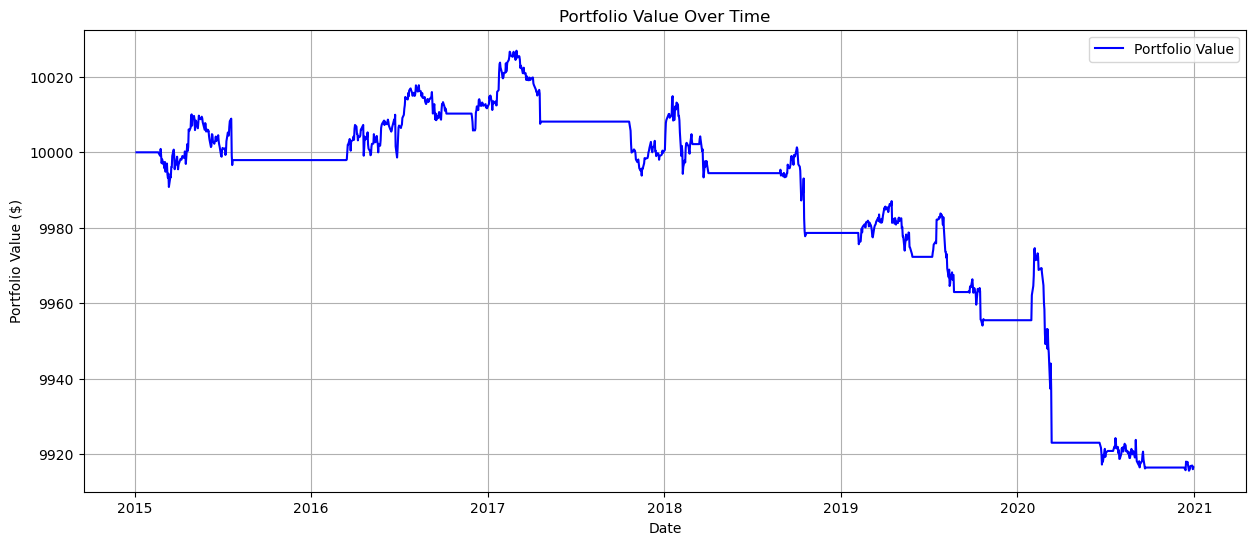

In [20]:
portfolio, signals = MA_strategy(df1, short_window=20, long_window=100)

### Mean Reversion

In [22]:
def mean_reversion_strategy(df, window, initial_capital=10000.0):
    # Initialize a new DataFrame to save signals
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Calculate rolling mean and standard deviation
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()

    # Calculate Bollinger Bands
    signals['upper_band'] = rolling_mean + (rolling_std * 2)
    signals['lower_band'] = rolling_mean - (rolling_std * 2)

    # Generate buy and sell signals
    signals['signal'] = np.where(df['Close'] < signals['lower_band'], 1.0, 0.0)
    signals['signal'] = np.where(df['Close'] > signals['upper_band'], -1.0, signals['signal'])
    
    # Take the difference of the signals to generate actual trading orders
    signals['positions'] = signals['signal'].diff()

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    #portfolio['holdings'] = signals['signal'] * df['Close']
    portfolio['holdings'] = signals['positions'] * (initial_capital / df['Close'].iloc[0])
    portfolio['cash'] = initial_capital - (signals['positions'] * df['Close']).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    # Plotting results
    plt.figure(figsize=(15, 6))

    # Plot closing price
    plt.plot(df['Close'], label='Close Price', alpha=0.5)

    # Plot Bollinger Bands
    plt.plot(signals['upper_band'], label='Upper Band', alpha=0.5)
    plt.plot(signals['lower_band'], label='Lower Band', alpha=0.5)

    # Plot buy signals (using markers on close price line)
    buy_idx = signals[signals.positions == 1.0].index
    plt.plot(buy_idx, df.loc[buy_idx, 'Close'], marker='^', markersize=10, color='g', label='Buy Signal', linestyle='None')

    # Plot sell signals (using markers on close price line)
    sell_idx = signals[signals.positions == -1.0].index
    plt.plot(sell_idx, df.loc[sell_idx, 'Close'], marker='v', markersize=10, color='r', label='Sell Signal', linestyle='None')

    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Mean Reversion Strategy with Signals')
    plt.grid(True)
    plt.legend()

    plt.show()

    # Plot portfolio value over time
    plt.figure(figsize=(15, 6))
    plt.plot(portfolio['total'], label='Portfolio Value', color='b')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.legend()

    plt.show()

    return portfolio, signals

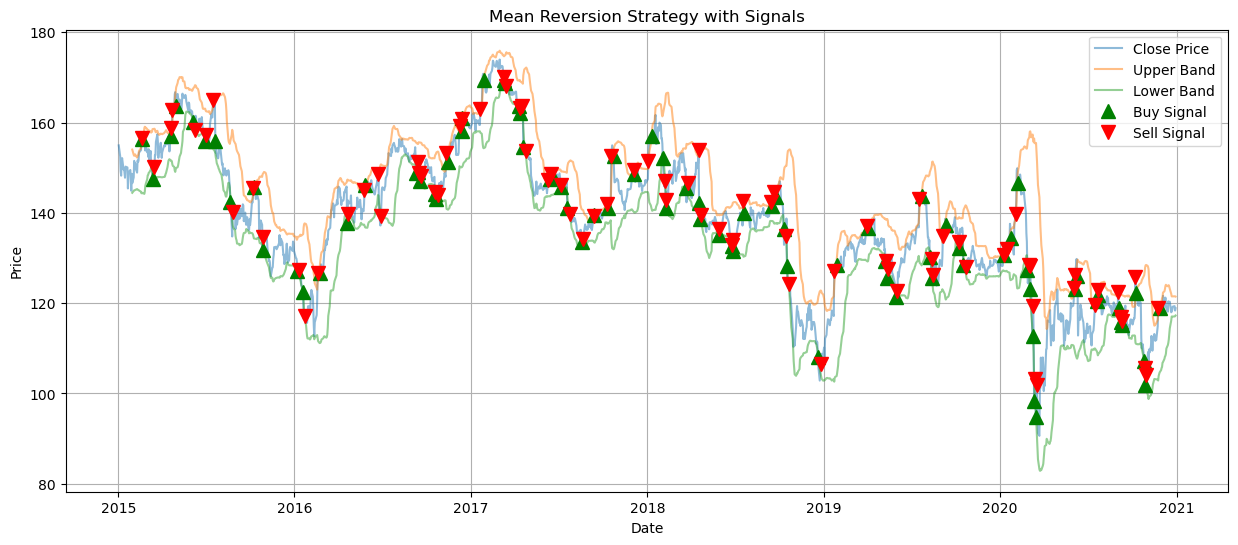

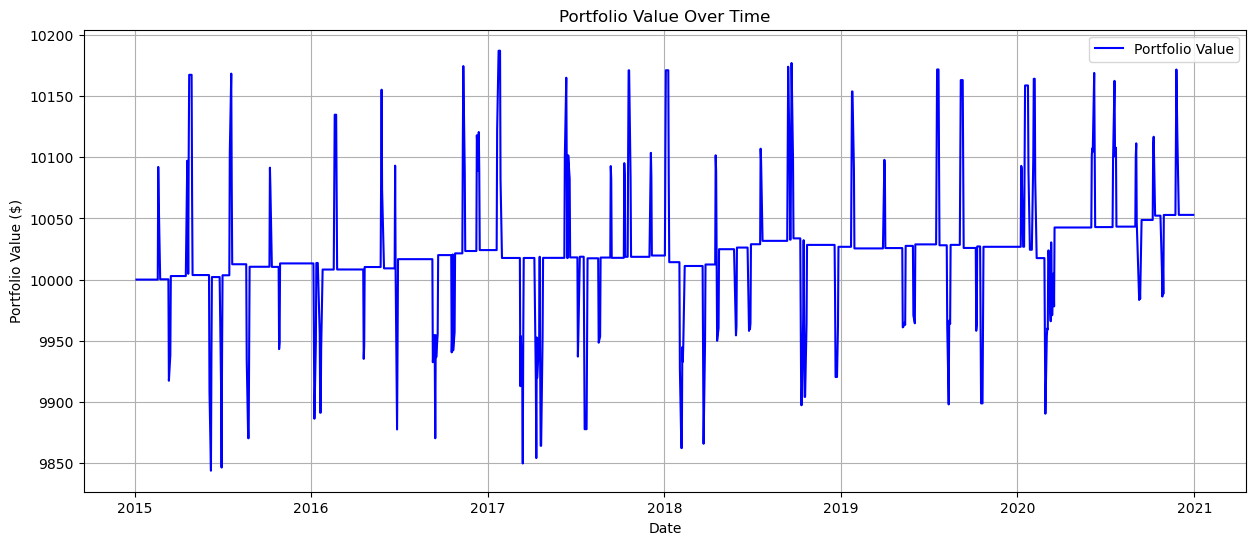

In [23]:
# Example usage:
# df1 should be a DataFrame with a 'Close' column containing the closing prices of the asset.
# df1 = pd.read_csv('path_to_your_data.csv', index_col='Date', parse_dates=True)
portfolio1, signals1 = mean_reversion_strategy(df1, window=20)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def bollinger_rsi_strategy(df, bollinger_window, rsi_window, rsi_low, rsi_high, initial_capital=10000.0):
    # Initialize a new DataFrame to save signals
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    # Calculate rolling mean and standard deviation for Bollinger Bands
    rolling_mean = df['Close'].rolling(window=bollinger_window).mean()
    rolling_std = df['Close'].rolling(window=bollinger_window).std()
    signals['upper_band'] = rolling_mean + (rolling_std * 2)
    signals['lower_band'] = rolling_mean - (rolling_std * 2)

    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_window).mean()
    rs = gain / loss
    signals['RSI'] = 100 - (100 / (1 + rs))

    # Generate buy and sell signals
    signals['signal'] = np.where((df['Close'] < signals['lower_band']) & (signals['RSI'] < rsi_low), 1.0, 0.0)
    signals['signal'] = np.where((df['Close'] > signals['upper_band']) & (signals['RSI'] > rsi_high), -1.0, signals['signal'])
    
    # Take the difference of the signals to generate actual trading orders
    signals['positions'] = signals['signal'].diff()

    # Initialize portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['holdings'] = signals['signal'] * df['Close']
    portfolio['cash'] = initial_capital - (signals['positions'] * df['Close']).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    # Plotting results
    plt.figure(figsize=(15, 6))

    # Plot closing price
    plt.plot(df['Close'], label='Close Price', alpha=0.5)

    # Plot Bollinger Bands
    plt.plot(signals['upper_band'], label='Upper Band', alpha=0.5)
    plt.plot(signals['lower_band'], label='Lower Band', alpha=0.5)

    # Plot buy signals (using markers on close price line)
    buy_idx = signals[signals.positions == 1.0].index
    plt.plot(buy_idx, df.loc[buy_idx, 'Close'], marker='^', markersize=10, color='g', label='Buy Signal', linestyle='None')

    # Plot sell signals (using markers on close price line)
    sell_idx = signals[signals.positions == -1.0].index
    plt.plot(sell_idx, df.loc[sell_idx, 'Close'], marker='v', markersize=10, color='r', label='Sell Signal', linestyle='None')

    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bollinger Bands and RSI Strategy with Signals')
    plt.grid(True)
    plt.legend()

    plt.show()

    # Plot portfolio value over time
    plt.figure(figsize=(15, 6))
    plt.plot(portfolio['total'], label='Portfolio Value', color='b')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.legend()

    plt.show()

    return portfolio, signals

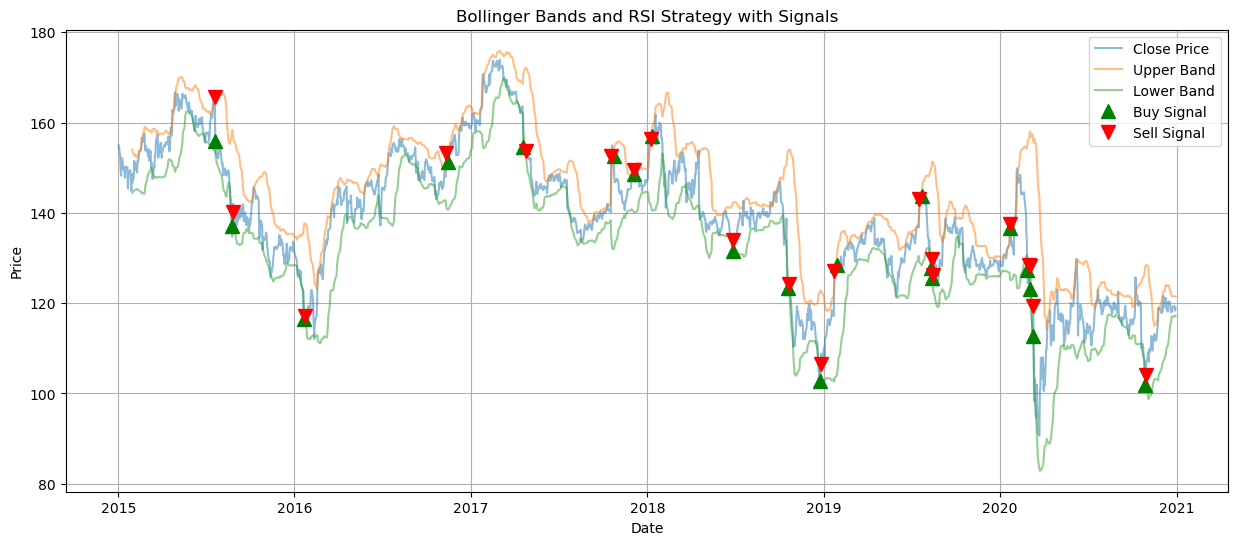

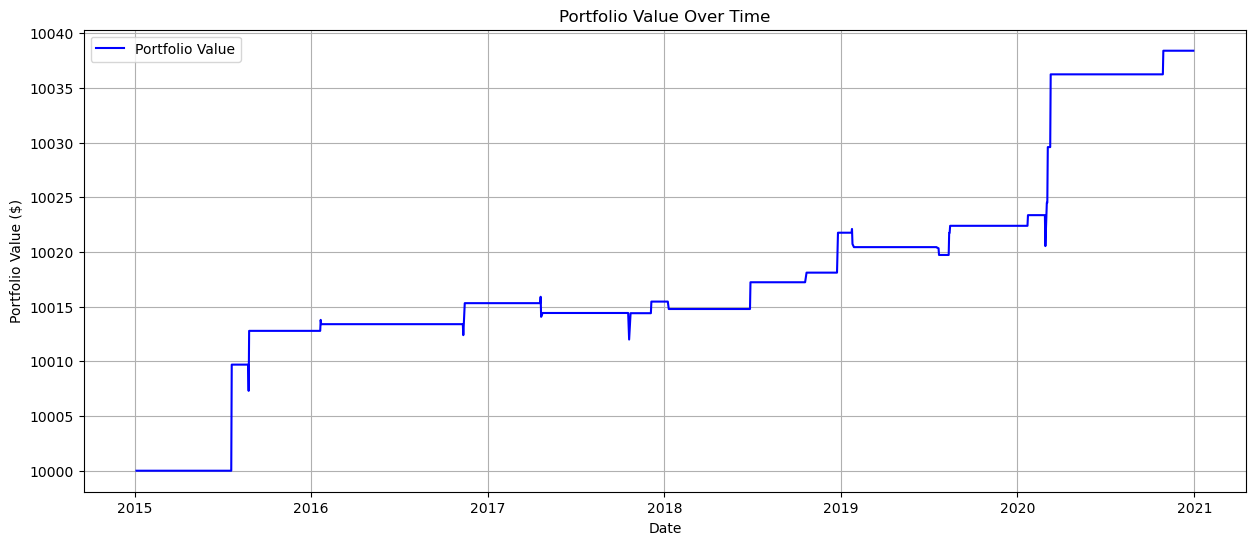

In [25]:

# Example usage:
# df1 should be a DataFrame with a 'Close' column containing the closing prices of the asset.
# df1 = pd.read_csv('path_to_your_data.csv', index_col='Date', parse_dates=True)
portfolio2, signals2 = bollinger_rsi_strategy(df1, bollinger_window=20, rsi_window=14, rsi_low=20, rsi_high=80)

In [26]:
def calculate_returns(df, signals):
    returns = pd.DataFrame(index=signals.index)
    returns['strategy_returns'] = signals['signal'].shift(1) * df['Close'].pct_change()
    returns['cumulative_returns'] = (1 + returns['strategy_returns']).cumprod()
    return returns

def compute_performance_metrics(returns):
    # Annualized Return
    cumulative_return = returns['cumulative_returns'].iloc[-1]
    annualized_return = cumulative_return ** (252 / len(returns)) - 1

    # Volatility
    volatility = returns['strategy_returns'].std() * np.sqrt(252)

    return annualized_return, volatility
def compute_sharpe_ratio(annualized_return, volatility, risk_free_rate=0.01):
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    return sharpe_ratio

In [27]:
signals

,signal,short_SMA,long_SMA,positions
Date,,,,
2015-01-02,0.0,154.933075,154.933075,NaN
2015-01-05,0.0,153.714149,153.714149,0.0
2015-01-06,0.0,152.211599,152.211599,0.0
2015-01-07,0.0,151.216537,151.216537,0.0
2015-01-08,0.0,151.263861,151.263861,0.0
...,...,...,...,...
2020-12-23,1.0,119.235181,116.394646,0.0
2020-12-24,1.0,119.258604,116.383652,0.0
2020-12-28,1.0,119.281070,116.377629,0.0


Moving Average Crossover Strategy: Annualized Return=-0.10610258301826192, Volatility=0.1596167796128517, Sharpe Ratio=-0.7273833195975206
Mean Reversion Strategy: Annualized Return=0.06900600505062493, Volatility=0.09972073749995174, Sharpe Ratio=0.5917124815753944
Momentum Strategy: Annualized Return=0.050225068538088946, Volatility=0.05122583844232721, Sharpe Ratio=0.785249588122925


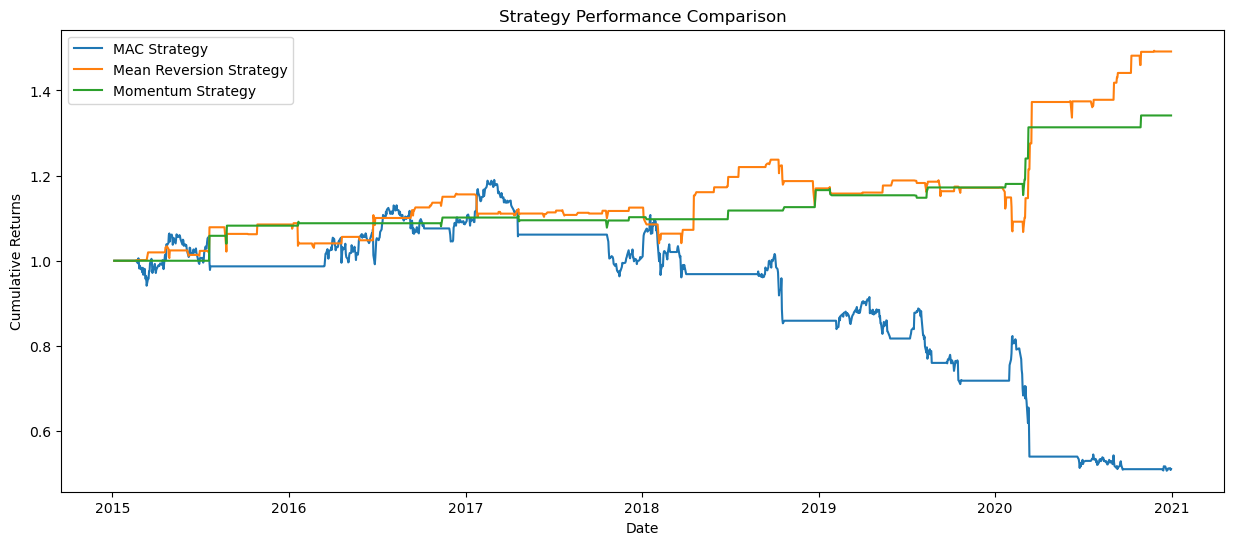

In [28]:
# Calculate returns
mac_returns = calculate_returns(df1, signals)
mr_returns = calculate_returns(df1, signals1)
mom_returns = calculate_returns(df1, signals2)

# Compute metrics
mac_annualized_return, mac_volatility = compute_performance_metrics(mac_returns)
mr_annualized_return, mr_volatility = compute_performance_metrics(mr_returns)
mom_annualized_return, mom_volatility = compute_performance_metrics(mom_returns)

mac_sharpe_ratio = compute_sharpe_ratio(mac_annualized_return, mac_volatility)
mr_sharpe_ratio = compute_sharpe_ratio(mr_annualized_return, mr_volatility)
mom_sharpe_ratio = compute_sharpe_ratio(mom_annualized_return, mom_volatility)

# Print results
print(f"Moving Average Crossover Strategy: Annualized Return={mac_annualized_return}, Volatility={mac_volatility}, Sharpe Ratio={mac_sharpe_ratio}")
print(f"Mean Reversion Strategy: Annualized Return={mr_annualized_return}, Volatility={mr_volatility}, Sharpe Ratio={mr_sharpe_ratio}")
print(f"Momentum Strategy: Annualized Return={mom_annualized_return}, Volatility={mom_volatility}, Sharpe Ratio={mom_sharpe_ratio}")

# Plot cumulative returns
plt.figure(figsize=(15, 6))
plt.plot(mac_returns['cumulative_returns'], label='MAC Strategy')
plt.plot(mr_returns['cumulative_returns'], label='Mean Reversion Strategy')
plt.plot(mom_returns['cumulative_returns'], label='Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Performance Comparison')
plt.legend()
plt.show()

Annualized return: The average annual return of an investment. It allows for easy comparison of returns across different time frames and investments. We compare the annualized returns of our strategy and the Dow Jones ETF to see which generated higher returns on average.

MR strategy had the highest.

Annualized volatility: A measure of the dispersion of returns around the average return. Higher volatility indicates greater risk. Comparing the annualized volatility of our strategy and the Dow Jones ETF shows which had more stable returns.

Momentum strategy had the lowest and hence has more stable returns.

Sharpe ratio: A risk-adjusted performance measure comparing excess return to volatility. It reveals whether returns are due to smart decisions or excessive risk. A higher Sharpe ratio indicates better risk-adjusted returns. We compare the Sharpe ratios to determine which offered better returns relative to risk.

MR Strategy has the highest SR abd hence better risk-adjusted returns

C:\Users\admin\AppData\Local\Temp\ipykernel_3636\3418628179.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0

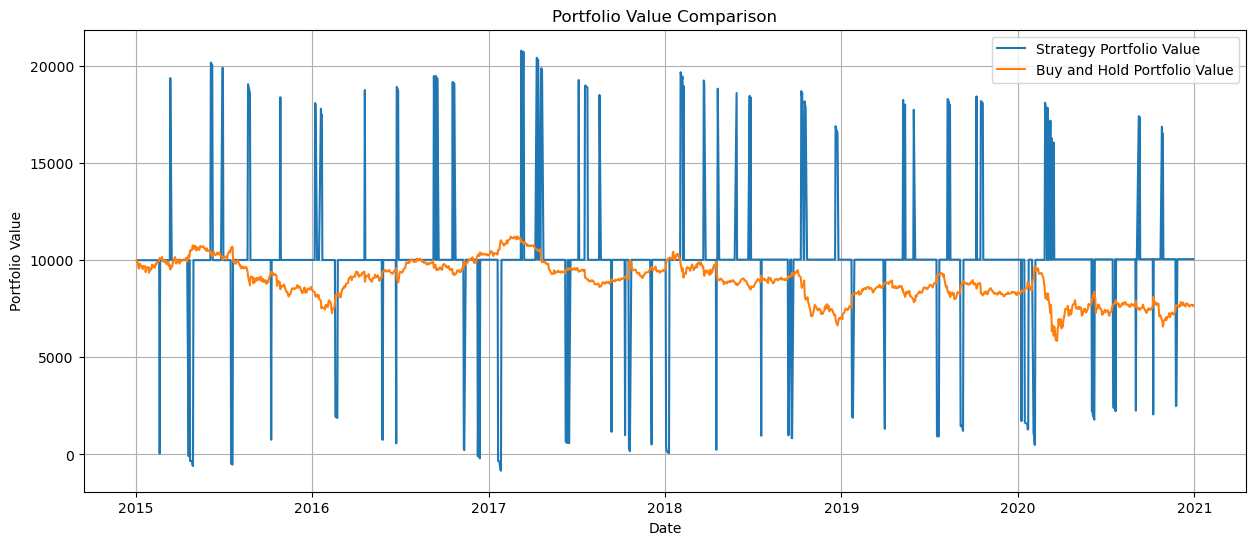

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def moving_average_crossover_strategy(df, short_window, long_window):
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    return signals

def calculate_portfolio_value(df, signals, initial_capital=10000):
    positions = signals['signal'] * df['Close']
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['holdings'] = positions * (initial_capital / df['Close'].iloc[0])
    portfolio['cash'] = initial_capital - (signals['positions'] * df['Close']).cumsum()
    portfolio['total'] = portfolio['holdings'] + portfolio['cash']
    return portfolio

# Load your data
# df1 = pd.read_csv('path_to_your_data.csv', index_col='Date', parse_dates=True)

# Parameters
short_window = 40
long_window = 100
initial_capital = 10000

# Run strategy
signals = moving_average_crossover_strategy(df1, short_window, long_window)
portfolio = calculate_portfolio_value(df1, signals1, initial_capital)

# Calculate buy-and-hold portfolio value
buy_and_hold = pd.DataFrame(index=df1.index)
buy_and_hold['total'] = initial_capital * (df1['Close'] / df1['Close'].iloc[0])

# Plot portfolio values
plt.figure(figsize=(15, 6))
plt.plot(portfolio['total'], label='Strategy Portfolio Value')
plt.plot(buy_and_hold['total'], label='Buy and Hold Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Parameters
short_window = 40
long_window = 100
initial_capital = 10000

# Run strategy
signals = moving_average_crossover_strategy(df1, short_window, long_window)
portfolio = calculate_portfolio_value(df1, signals, initial_capital)

# Calculate buy-and-hold portfolio value
buy_and_hold = pd.DataFrame(index=df1.index)
buy_and_hold['total'] = initial_capital * (df1['Close'] / df1['Close'].iloc[0])



C:\Users\admin\AppData\Local\Temp\ipykernel_3636\3418628179.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0

In [82]:
portfolio

,holdings,cash,total
Date,,,
2015-01-02,0.0,NaN,NaN
2015-01-05,0.0,10000.000000,10000.000000
2015-01-06,0.0,10000.000000,10000.000000
2015-01-07,0.0,10000.000000,10000.000000
2015-01-08,0.0,10000.000000,10000.000000
...,...,...,...
2020-12-23,0.0,9899.273422,9899.273422
2020-12-24,0.0,9899.273422,9899.273422
2020-12-28,0.0,9899.273422,9899.273422


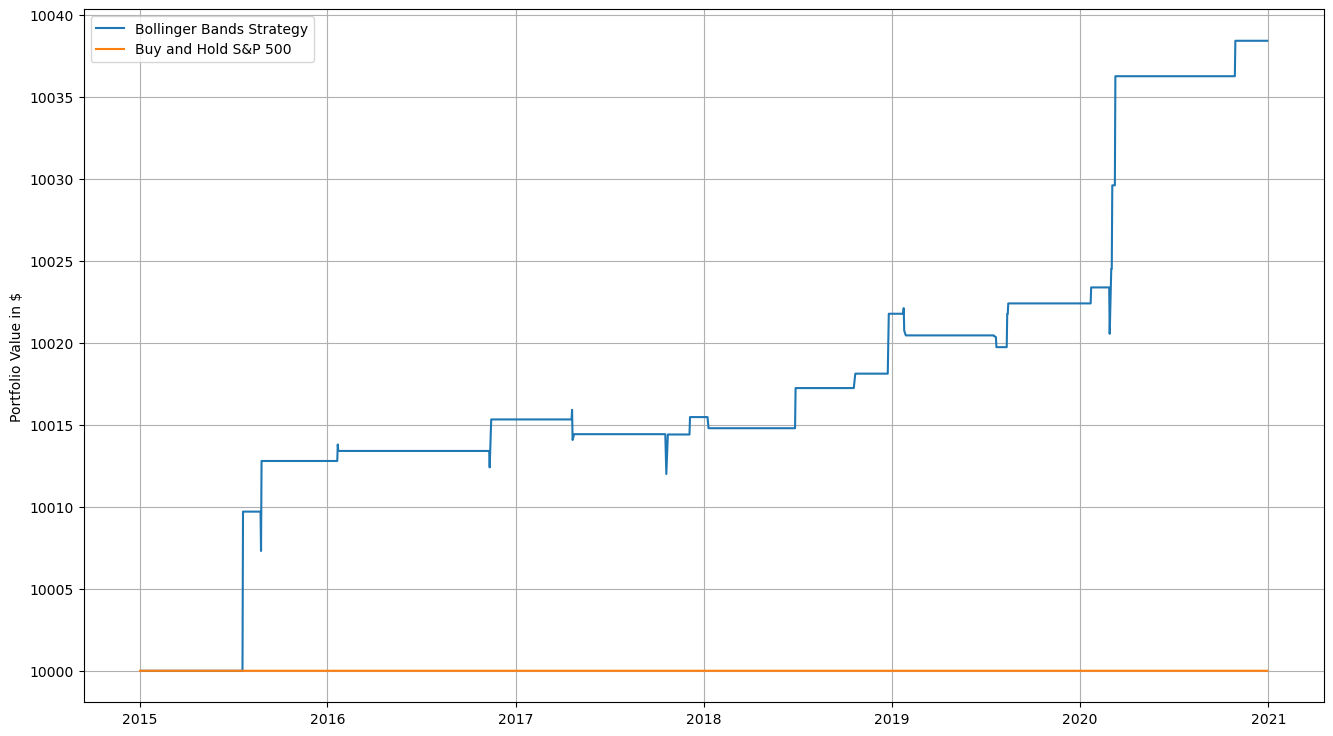

In [88]:
# Create a new dataframe to hold the 'Buy and Hold' strategy
bh_portfolio = pd.DataFrame(index=df1.index)
bh_portfolio['Close'] = df1['Close']

initial_capital = 10000

# Buy at the start and hold
bh_portfolio['Holdings'] = initial_capital/bh_portfolio.iloc[0]['Close']*bh_portfolio['Close']
bh_portfolio['Cash'] = initial_capital - bh_portfolio['Holdings']
bh_portfolio['Total'] = bh_portfolio['Cash'] + bh_portfolio['Holdings']
bh_portfolio['Returns'] = bh_portfolio['Total'].pct_change()

# Plot both the Bollinger Bands strategy and 'Buy and Hold' strategy
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(portfolio.index, portfolio2['total'], label='Bollinger Bands Strategy')
ax.plot(bh_portfolio.index, bh_portfolio['Total'], label='Buy and Hold S&P 500')
ax.set_ylabel('Portfolio Value in $')
ax.legend(loc='best')
ax.grid()

plt.show()

In [ ]:
# Calculate the cumulative returns for our mean reversion strategy and the DIA ETF
capital_over_time['Capital_Returns'] = capital_over_time['Capital'].pct_change() + 1
dia_cumulative_returns = (dia_data.pct_change() + 1).cumprod()

# Multiply the cumulative returns by the initial investment of $100,000 to get the daily portfolio values
capital_over_time['Portfolio_Value'] = capital_over_time['Capital_Returns'].cumprod() * 100000
dia_portfolio_value = dia_cumulative_returns * 100000

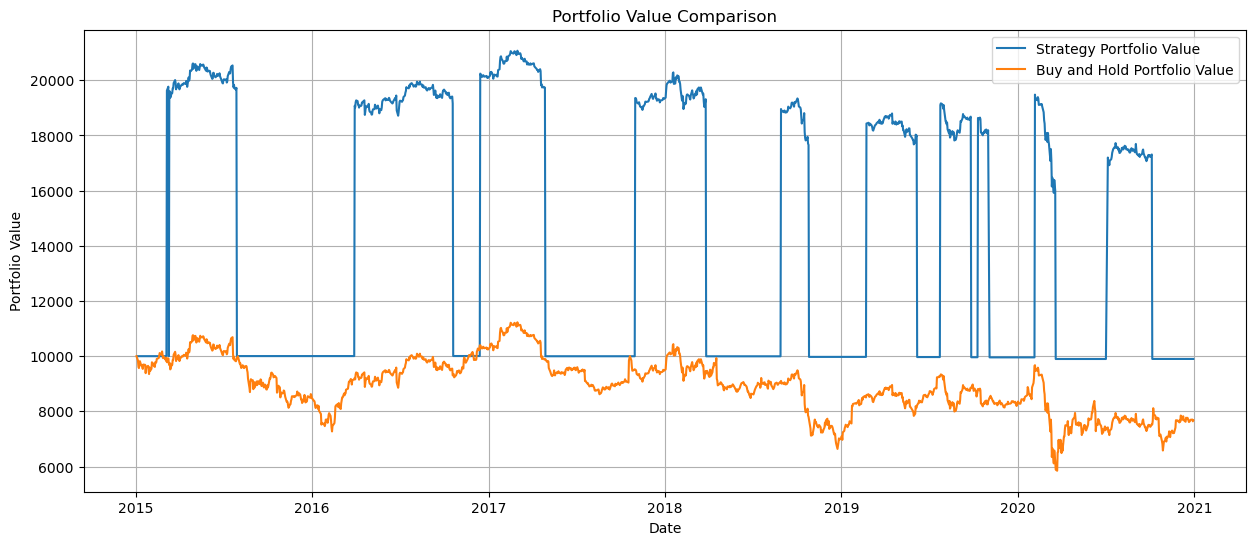

In [70]:
# Plot portfolio values
plt.figure(figsize=(15, 6))
plt.plot(portfolio['total'], label='Strategy Portfolio Value')
plt.plot(buy_and_hold['total'], label='Buy and Hold Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
def calculate_sharpe_ratio(df, initial_capital=10000, risk_free_rate=0.01):
    # Calculate daily returns
    df['daily_return'] = df['Close'].pct_change()

    # Calculate portfolio value for buy-and-hold strategy
    df['portfolio_value'] = initial_capital * (df['Close'] / df['Close'].iloc[0])
    
    # Calculate daily returns of the portfolio
    df['strategy_return'] = df['portfolio_value'].pct_change()

    # Drop NaN values that may result from pct_change() calculations
    df = df.dropna()

    # Calculate average daily return and standard deviation of daily returns
    avg_daily_return = df['strategy_return'].mean()
    daily_volatility = df['strategy_return'].std()

    # Annualize the average return and volatility
    annualized_return = (1 + avg_daily_return) ** 252 - 1
    annualized_volatility = daily_volatility * np.sqrt(252)

    # Calculate Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return annualized_return, annualized_volatility, sharpe_ratio

# Load your data
# df1 = pd.read_csv('path_to_your_data.csv', index_col='Date', parse_dates=True)

# Parameters
initial_capital = 10000
risk_free_rate = 0.01  # Risk-free rate, for example, 1%

# Calculate Sharpe Ratio for buy-and-hold strategy
annualized_return, annualized_volatility, sharpe_ratio = calculate_sharpe_ratio(df1, initial_capital, risk_free_rate)

# Print results
print(f"Annualized Return: {annualized_return:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Annualized Return: -0.0123
Annualized Volatility: 0.2520
Sharpe Ratio: -0.0884


In [92]:
# Initial capital
initial_capital = 10000
position = 0
portfolio_value = []

data = df1

# Calculate moving averages
data['SMA_short'] = data['Close'].rolling(window=50).mean()
data['SMA_long'] = data['Close'].rolling(window=200).mean()

for i in range(len(data)):
    if data['SMA_short'][i] > data['SMA_long'][i]:
        if position == 0:
            buy_price = data['Close'][i]
            shares = initial_capital // buy_price
            position = 1
            portfolio_value.append(initial_capital)
        else:
            portfolio_value.append(portfolio_value[-1])
    elif data['SMA_short'][i] < data['SMA_long'][i]:
        if position == 1:
            sell_price = data['Close'][i]
            initial_capital = shares * sell_price
            position = 0
            portfolio_value.append(initial_capital)
        else:
            portfolio_value.append(portfolio_value[-1])
    else:
        portfolio_value.append(portfolio_value[-1])


C:\Users\admin\AppData\Local\Temp\ipykernel_3636\2777854373.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['SMA_short'][i] > data['SMA_long'][i]:
C:\Users\admin\AppData\Local\Temp\ipykernel_3636\2777854373.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['SMA_short'][i] < data['SMA_long'][i]:


IndexError: list index out of range